In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


--- Successfully loaded data from CSV ---
            temperature  humidity  aqi  is_weekend  mishaps_independence_day  \
date                                                                           
2019-01-01         21.4      80.4   92           0                         0   
2019-01-02         20.6      65.0  115           0                         1   
2019-01-03         22.9      82.6  143           0                         1   
2019-01-04         19.4      74.8  102           0                         1   
2019-01-05         20.2      77.1  142           1                         0   

            mishaps_ganesh_chaturthi  mishaps_diwali  mishaps_holi  \
date                                                                 
2019-01-01                         0               0             0   
2019-01-02                         0               0             0   
2019-01-03                         0               0             0   
2019-01-04                         0           

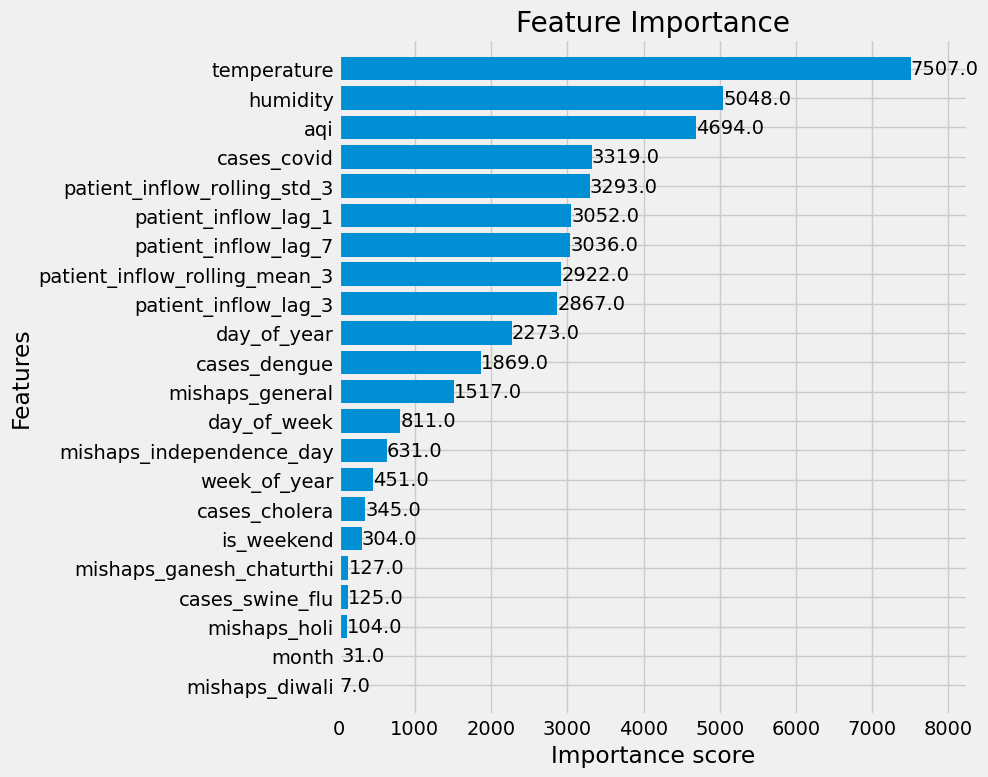

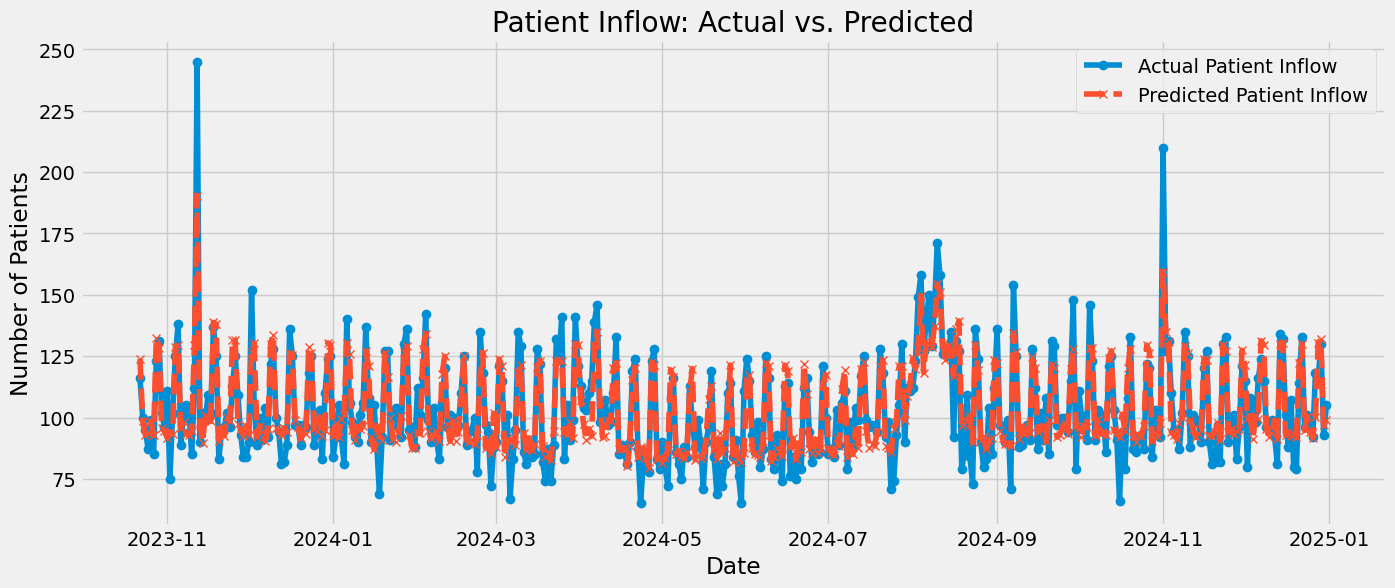

In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- 1. Data Loading & Preprocessing ---
# Load the dataset from the specified CSV file path.
# We parse the 'date' column directly into datetime objects for efficiency.
try:
    df = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/HOS_Agents/synthetic_hospital_data_2019_2024.csv',
        parse_dates=['date']
    )
    df = df.set_index('date')
    print("--- Successfully loaded data from CSV ---")
    print(df.head())
except FileNotFoundError:
    print("Error: The specified file was not found.")
    print("Please make sure the path is correct and the file is accessible.")
    # As a fallback, create an empty DataFrame to prevent the script from crashing.
    df = pd.DataFrame()

# --- 2. Feature Engineering for Time Series ---
if not df.empty:
    # Create features from the date index.
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['week_of_year'] = df.index.isocalendar().week.astype(int)

    # Create lag features for the target variable.
    def create_lag_features(df, target_col, lags):
        for lag in lags:
            df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
        return df

    df = create_lag_features(df, 'patient_inflow', [1, 3, 7])

    # Create rolling window features for the target variable.
    df['patient_inflow_rolling_mean_3'] = df['patient_inflow'].shift(1).rolling(window=3).mean()
    df['patient_inflow_rolling_std_3'] = df['patient_inflow'].shift(1).rolling(window=3).std()


    # Drop rows with NaN values created by lag/rolling features
    df = df.dropna()

    print("\n--- Data After Feature Engineering ---")
    print(df.head())


    # --- 3. Model Training ---
    # Define features (X) and target (y)
    # Ensure these column names match your CSV file.
    FEATURES = [
        'temperature', 'humidity', 'aqi', 'is_weekend',
        'mishaps_independence_day', 'mishaps_ganesh_chaturthi', 'mishaps_diwali', 'mishaps_holi', 'mishaps_general',
        'cases_dengue', 'cases_covid', 'cases_swine_flu', 'cases_cholera',
        'day_of_week', 'day_of_year', 'month', 'quarter', 'week_of_year',
        'patient_inflow_lag_1', 'patient_inflow_lag_3', 'patient_inflow_lag_7',
        'patient_inflow_rolling_mean_3', 'patient_inflow_rolling_std_3'
    ]
    TARGET = 'patient_inflow'

    # Verify that all feature columns exist in the DataFrame
    missing_cols = [col for col in FEATURES if col not in df.columns]
    if missing_cols:
        print(f"\nError: The following feature columns are missing from your CSV file: {missing_cols}")
    else:
        X = df[FEATURES]
        y = df[TARGET]

        # Split data into training and testing sets without shuffling for time series
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        print(f"\nTraining data shape: {X_train.shape}")
        print(f"Testing data shape: {X_test.shape}")

        # Initialize and train the XGBoost Regressor model
        reg = xgb.XGBRegressor(
            n_estimators=3000,
            learning_rate=0.05,
            eval_metric='rmse',
            early_stopping_rounds=1000
        )

        # The model is evaluated on the test set during training for early stopping
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)


        # --- 4. Evaluation and Prediction ---
        # Make predictions on the test set
        y_pred = reg.predict(X_test)

        # Calculate the Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"\nRoot Mean Squared Error (RMSE) on Test Set: {rmse:.2f}")

        # Create a DataFrame to compare actual vs. predicted values
        results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
        print("\n--- Actual vs. Predicted ---")
        print(results)


        # --- 5. Feature Importance ---
        # Plot feature importance to see which factors the model found most predictive
        plt.style.use('fivethirtyeight')
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(reg, ax=ax, height=0.8, title="Feature Importance")
        plt.tight_layout()
        plt.show()

        # --- 6. Visualize Predictions ---
        # Plot the actual and predicted values over time
        plt.figure(figsize=(15, 6))
        plt.plot(y_test.index, y_test, label='Actual Patient Inflow', marker='o')
        plt.plot(y_test.index, y_pred, label='Predicted Patient Inflow', linestyle='--', marker='x')
        plt.title('Patient Inflow: Actual vs. Predicted')
        plt.xlabel('Date')
        plt.ylabel('Number of Patients')
        plt.legend()
        plt.grid(True)
        plt.show()


--- Successfully loaded data from CSV ---
            temperature  humidity  aqi  is_weekend  mishaps_independence_day  \
date                                                                           
2019-01-01         21.4      80.4   92           0                         0   
2019-01-02         20.6      65.0  115           0                         1   
2019-01-03         22.9      82.6  143           0                         1   
2019-01-04         19.4      74.8  102           0                         1   
2019-01-05         20.2      77.1  142           1                         0   

            mishaps_ganesh_chaturthi  mishaps_diwali  mishaps_holi  \
date                                                                 
2019-01-01                         0               0             0   
2019-01-02                         0               0             0   
2019-01-03                         0               0             0   
2019-01-04                         0           

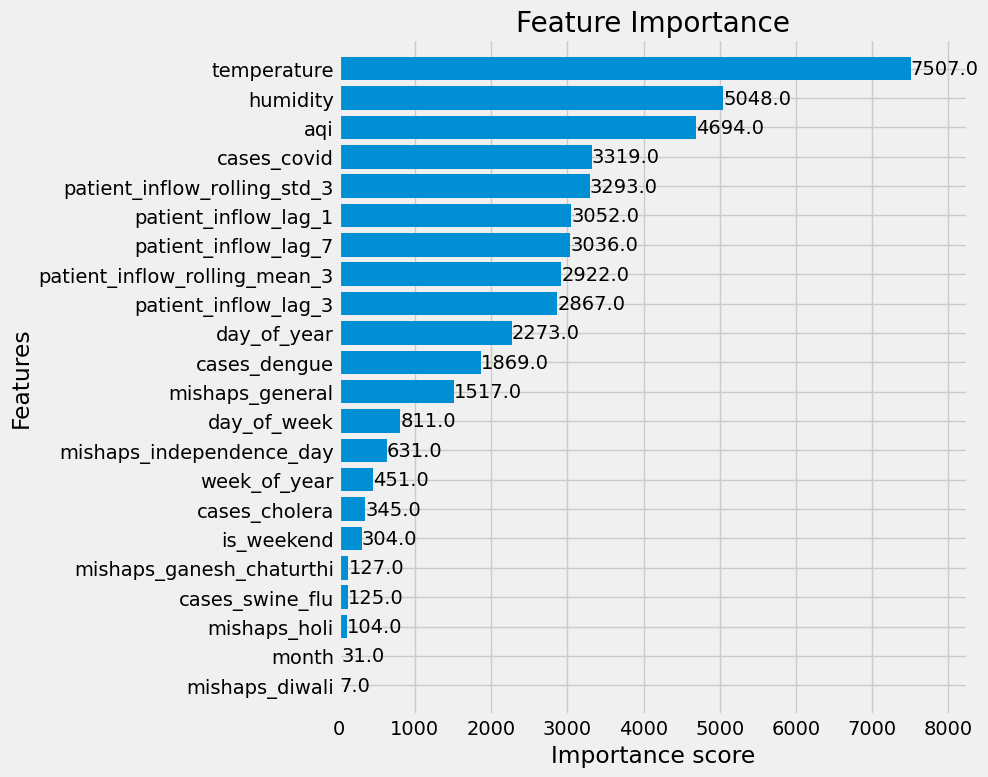

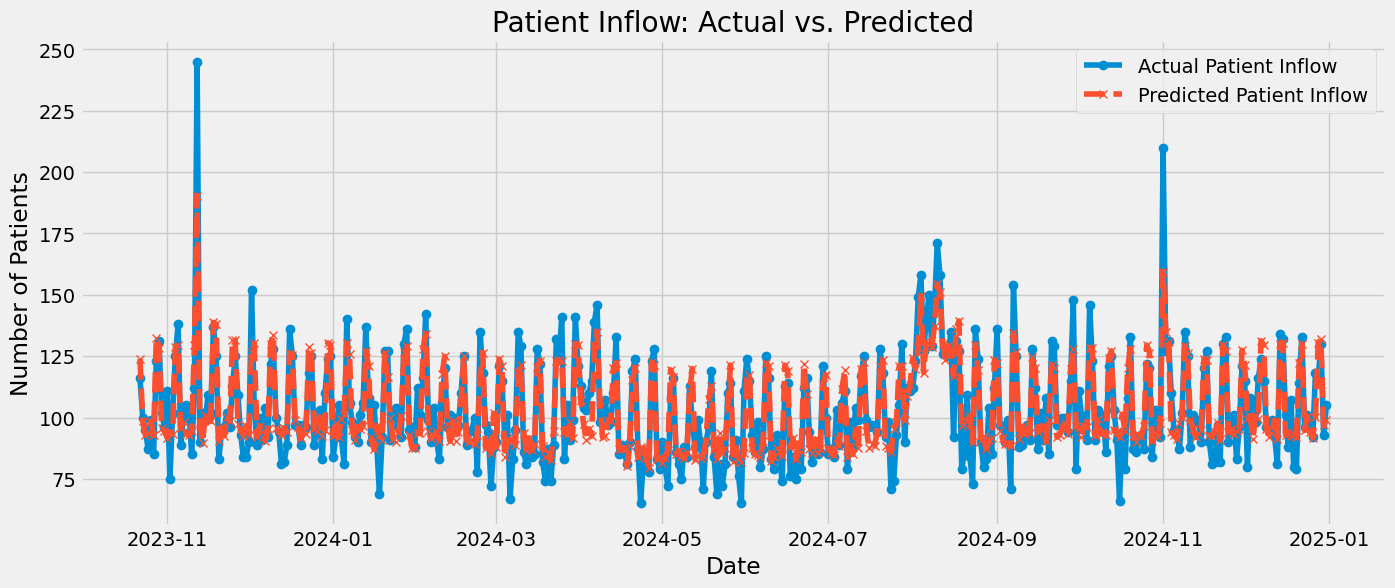


--- Preparing Model Artifacts ---
Model saved to hospital_patient_forecaster/xgboost_patient_forecaster.json
requirements.txt created at hospital_patient_forecaster/requirements.txt
README.md created at hospital_patient_forecaster/README.md

--- Starting Deployment to Hugging Face ---
Please enter your Hugging Face WRITE token in the upcoming prompt.


Preparing to upload to shreyaspb/hospital-patient-forecaster_v...

--- DEPLOYMENT COMPLETE ---
Success! Your model has been uploaded to: https://huggingface.co/shreyaspb/hospital-patient-forecaster_v


In [20]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# --- 0. Install Hugging Face Library ---
# This command will run in a Colab environment to install the necessary package.
!pip install huggingface_hub -q

from huggingface_hub import notebook_login, HfApi

# --- 1. Data Loading & Preprocessing ---
# Load the dataset from the specified CSV file path.
# We parse the 'date' column directly into datetime objects for efficiency.
try:
    df = pd.read_csv(
        '/content/drive/MyDrive/Colab Notebooks/HOS_Agents/synthetic_hospital_data_2019_2024.csv',
        parse_dates=['date']
    )
    df = df.set_index('date')
    print("--- Successfully loaded data from CSV ---")
    print(df.head())
except FileNotFoundError:
    print("Error: The specified file was not found.")
    print("Please make sure the path is correct and the file is accessible.")
    # As a fallback, create an empty DataFrame to prevent the script from crashing.
    df = pd.DataFrame()

# --- 2. Feature Engineering for Time Series ---
if not df.empty:
    # Create features from the date index.
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['week_of_year'] = df.index.isocalendar().week.astype(int)

    # Create lag features for the target variable.
    def create_lag_features(df, target_col, lags):
        for lag in lags:
            df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
        return df

    df = create_lag_features(df, 'patient_inflow', [1, 3, 7])

    # Create rolling window features for the target variable.
    df['patient_inflow_rolling_mean_3'] = df['patient_inflow'].shift(1).rolling(window=3).mean()
    df['patient_inflow_rolling_std_3'] = df['patient_inflow'].shift(1).rolling(window=3).std()


    # Drop rows with NaN values created by lag/rolling features
    df = df.dropna()

    print("\n--- Data After Feature Engineering ---")
    print(df.head())


    # --- 3. Model Training ---
    # Define features (X) and target (y)
    # Ensure these column names match your CSV file.
    FEATURES = [
        'temperature', 'humidity', 'aqi', 'is_weekend',
        'mishaps_independence_day', 'mishaps_ganesh_chaturthi', 'mishaps_diwali', 'mishaps_holi', 'mishaps_general',
        'cases_dengue', 'cases_covid', 'cases_swine_flu', 'cases_cholera',
        'day_of_week', 'day_of_year', 'month', 'quarter', 'week_of_year',
        'patient_inflow_lag_1', 'patient_inflow_lag_3', 'patient_inflow_lag_7',
        'patient_inflow_rolling_mean_3', 'patient_inflow_rolling_std_3'
    ]
    TARGET = 'patient_inflow'

    # Verify that all feature columns exist in the DataFrame
    missing_cols = [col for col in FEATURES if col not in df.columns]
    if missing_cols:
        print(f"\nError: The following feature columns are missing from your CSV file: {missing_cols}")
    else:
        X = df[FEATURES]
        y = df[TARGET]

        # Split data into training and testing sets without shuffling for time series
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        print(f"\nTraining data shape: {X_train.shape}")
        print(f"Testing data shape: {X_test.shape}")

        # Initialize and train the XGBoost Regressor model
        reg = xgb.XGBRegressor(
            n_estimators=3000,
            learning_rate=0.05,
            eval_metric='rmse',
            early_stopping_rounds=1000
        )

        # The model is evaluated on the test set during training for early stopping
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)


        # --- 4. Evaluation and Prediction ---
        # Make predictions on the test set
        y_pred = reg.predict(X_test)

        # Calculate the Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"\nRoot Mean Squared Error (RMSE) on Test Set: {rmse:.2f}")

        # Create a DataFrame to compare actual vs. predicted values
        results = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
        print("\n--- Actual vs. Predicted ---")
        print(results)


        # --- 5. Feature Importance ---
        # Plot feature importance to see which factors the model found most predictive
        plt.style.use('fivethirtyeight')
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(reg, ax=ax, height=0.8, title="Feature Importance")
        plt.tight_layout()
        plt.show()

        # --- 6. Visualize Predictions ---
        # Plot the actual and predicted values over time
        plt.figure(figsize=(15, 6))
        plt.plot(y_test.index, y_test, label='Actual Patient Inflow', marker='o')
        plt.plot(y_test.index, y_pred, label='Predicted Patient Inflow', linestyle='--', marker='x')
        plt.title('Patient Inflow: Actual vs. Predicted')
        plt.xlabel('Date')
        plt.ylabel('Number of Patients')
        plt.legend()
        plt.grid(True)
        plt.show()

        # --- 7. Save Model Artifacts ---
        print("\n--- Preparing Model Artifacts ---")

        # Create a directory to store model artifacts
        repo_dir = "hospital_patient_forecaster"
        os.makedirs(repo_dir, exist_ok=True)

        # a. Save the final trained model
        model_filename = "xgboost_patient_forecaster.json"
        model_path = os.path.join(repo_dir, model_filename)
        reg.save_model(model_path)
        print(f"Model saved to {model_path}")

        # b. Create the requirements.txt file
        requirements_content = "xgboost\nscikit-learn\npandas\nnumpy"
        requirements_path = os.path.join(repo_dir, "requirements.txt")
        with open(requirements_path, "w") as f:
            f.write(requirements_content)
        print(f"requirements.txt created at {requirements_path}")

        # c. Create the README.md (Model Card)
        readme_content = f"""---
license: mit
tags:
- time-series
- regression
- xgboost
---
# XGBoost Model for Hospital Patient Inflow Forecasting
This model predicts daily hospital patient inflow based on time-series, environmental, and event data.
RMSE on the test set: **{rmse:.2f} patients**.
"""
        readme_path = os.path.join(repo_dir, "README.md")
        with open(readme_path, "w") as f:
            f.write(readme_content.strip())
        print(f"README.md created at {readme_path}")

        # --- 8. Deploy to Hugging Face Hub ---
        print("\n--- Starting Deployment to Hugging Face ---")

        # Step 8a: Login to Hugging Face
        # This will create a popup where you can paste your WRITE token.
        print("Please enter your Hugging Face WRITE token in the upcoming prompt.")
        notebook_login()

        # Step 8b: Set your username and repo name
        # --- IMPORTANT: CHANGE THIS TO YOUR HF USERNAME ---
        YOUR_HF_USERNAME = 'shreyaspb'
        # -------------------------------------------------
        REPO_NAME = 'hospital-patient-forecaster_v'

        # Step 8c: Create the repo and upload the files
        print(f"Preparing to upload to {YOUR_HF_USERNAME}/{REPO_NAME}...")
        api = HfApi()

        api.create_repo(
            repo_id=f"{YOUR_HF_USERNAME}/{REPO_NAME}",
            repo_type="model",
            exist_ok=True,
        )

        api.upload_folder(
            folder_path=repo_dir,
            repo_id=f"{YOUR_HF_USERNAME}/{REPO_NAME}",
            repo_type="model",
        )

        print("\n--- DEPLOYMENT COMPLETE ---")
        print(f"Success! Your model has been uploaded to: https://huggingface.co/{YOUR_HF_USERNAME}/{REPO_NAME}")
